In [2]:
import faiss
import os
import numpy as np
from IPython.display import display, Image
from PIL import Image as PILImage
import lmdb
import torch 
import io
from misc.model import joint_embedding
from torchvision import transforms
from misc.utils import save_obj, collate_fn_cap_padded, encode_sentence
import h5py

In [3]:
device = torch.device("cuda")
index_path = "flickr30k_flat_full.index"
h5_path = "embeddings_sentences_full.h5"
model_path = "weights/best_correct_full_cs.pth.tar"
dict_path = "/data/m.portaz/wiki.multi.en.vec"

index = faiss.read_index(str(index_path))
index_search = index.search

In [8]:
checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)

join_emb = joint_embedding(checkpoint['args_dict'])
join_emb.load_state_dict(checkpoint["state_dict"])

for param in join_emb.parameters():
    param.requires_grad = False

join_emb.to(device)
join_emb.eval()

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

prepro_val = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    normalize,
])


tf_img = prepro_val

def load_vec(emb_path):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

embeddings_fr, id2word_fr, word2id_fr = load_vec("/data/m.portaz/wiki.multi.fr.vec")
embeddings_en, id2word_en, word2id_en = load_vec("/data/m.portaz/wiki.multi.en.vec")
embeddings_de, id2word_de, word2id_de = load_vec("/data/m.portaz/wiki.multi.de.vec")

def get_features_sentence(sentence, lang):
    if lang == 'fr':
        input_sentence = encode_sentence(sentence, embeddings_fr, word2id_fr)
    elif lang == 'en':
        input_sentence = encode_sentence(sentence, embeddings_en, word2id_en)
    elif lang == 'de':
        input_sentence = encode_sentence(sentence, embeddings_de, word2id_de)
        
    input_caps = input_sentence.unsqueeze(0).to(device)

    with torch.no_grad():
        _, output_emb = join_emb(None, input_caps, [len(sentence.split(' '))])
    return output_emb.detach().cpu().numpy()

In [9]:
def getSentences(uuids):
    with h5py.File(h5_path, 'r') as f:
        sentences = f['sentence']
        for caption_id in uuids[0]:
            print(sentences[int(caption_id)])

In [10]:
def printNeighboursSentence(sentence,  nb_neigbours, lang=):
    embedding_words = get_features_sentence(sentence, lang)
    dists, uuids = index_search(embedding_words, nb_neigbours)
    getSentences(uuids)

SyntaxError: invalid syntax (<ipython-input-10-b3bedb7633ba>, line 1)

In [ ]:
printNeighboursSentence('une femme sur un banc', 10, 'fr')

In [ ]:
printNeighboursSentence('a man on a beach building a sand castle', 10, 'en')

In [55]:
def get_features_image(image_path):
    img = PILImage.open(image_path, mode="r")

    if img.mode is 'L':
        rgbimg = Image.new("RGB", img.size)
        rgbimg.paste(img)
        img = rgbimg
    if img.mode is not 'RGB':
        img = img.convert('RGB')

    img = tf_img(img)

    input_img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output, _ = join_emb(input_img, None, None)
    return output.detach().cpu().numpy()

In [62]:
def printNeighboursImages(image_path, nb_neigbours):
    embedding_image = get_features_image(image_path)
    edists, uuids = index_search(embedding_image, nb_neigbours)
    getSentences(uuids)

In [85]:
printNeighboursImages('/data/m.portaz/saut.jpg', 10)

une personne fait du parachute au-dessus d&apos; une vaste étendue d&apos; eau .

eine person in winterkleidung posiert mit einem schneemann und ist dabei von einer schneebedeckten landschaft umgeben .

une personne fait de la planche à voile sur la crête d&apos; une vague .

une personne sur une motoneige en plein saut .

ein skifahrer fliegt durch die luft , während ihm andere skifahrer , die mit dem schlepplift fahren , dabei zusehen .

un homme portant un bonnet et des lunettes d&apos; aviateur est assis sur la route .

un skieur vole dans les airs , tandis que d&apos; autres skieurs prenant le tire-fesse le regardent .

a person on a snowmobile in mid jump .

da ist ein mann , der in irgendeine decke gewickelt ist und einen schneebedeckten hügel herunterrutscht .

il y a plusieurs personnes faisant un looping dans des montagnes russes à l&apos; envers .



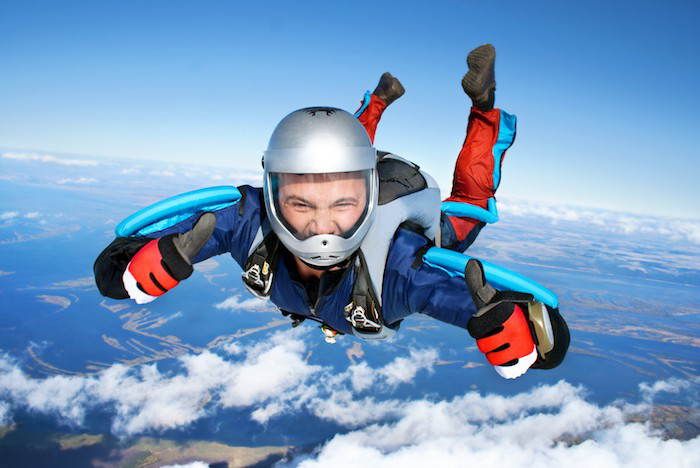

In [86]:
PILImage.open('/data/m.portaz/saut.jpg')

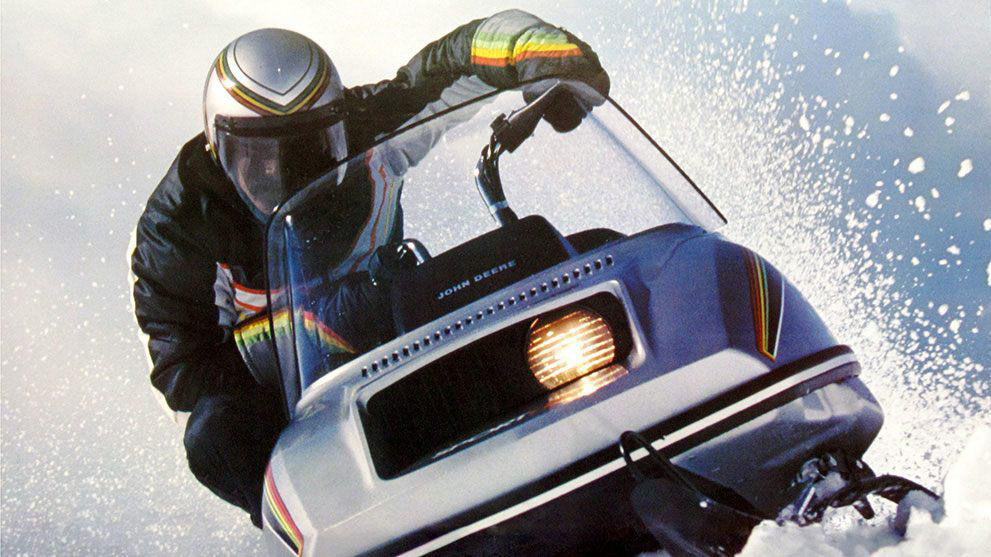

In [88]:
PILImage.open('/data/a.nivaggioli/Datasets/ConceptualCaptions/Images/0002362936.jpg')

In [87]:
printNeighboursImages('/data/a.nivaggioli/Datasets/ConceptualCaptions/Images/0002362936.jpg', 10)

eine person fährt auf ihrem geländemotorrad .

un homme emmitouflé dans une nacelle , travaillant sur une ligne électrique par temps froid .

a man wearing an aviation cap and goggles sits in the road .

ein blauer jeep fährt in tiefes , schlammiges wasser .

un homme portant un casque multicolore brillant est assis sur une moto .

une personne sur une motoneige en plein saut .

la voiture laisse une traînée de poussière tandis qu&apos; elle roule sur la piste en terre .

a person on a snowmobile in mid jump .

ein mann in einem blauen hemd fährt mit fackeln in der hand auf einem einrad .

ein junger skifahrer blickt in die kamera .

